<a href="https://colab.research.google.com/github/asjnhy/NLP-Bert/blob/master/Bert-CNN-Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers
!pip install konlpy
!pip install -U imbalanced-learn

In [0]:
import tensorflow as tf
import torch

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import random
import time
import datetime

from konlpy.tag import *

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



## Dataset Preprocessing

#####1. UnderSampling, training set = 200
#####2. Insert [CLS] ,[SEP], Tokenize

#####3. Input for Bert : input, attention_masks,  label
#####4, split into training set(labeled), validation set(labeled)




In [0]:
train = pd.read_csv('/content/drive/My Drive/submission/0_Data/train.csv')
test = pd.read_csv('/content/drive/My Drive/submission/0_Data/public_test.csv')
print(train.shape)
print(test.shape)

(295945, 4)
(1626, 3)


In [0]:
from imblearn.under_sampling import RandomUnderSampler
train_list = np.array(train.index).reshape(-1,1)
X, y= RandomUnderSampler(random_state=0).fit_sample(train_list,train['smishing'])

In [0]:
train_smishing = []
train_nonsmishing = []
for a,b in zip(X,y):
    if (b == 1):
        train_smishing.append(a[0])
    else: 
        train_nonsmishing.append(a[0])
train=train.iloc[train_smishing+train_nonsmishing,:].reset_index(drop=True)
print(len(train))

37406


In [0]:
#스미싱 문자 100개, 스미싱 x 문자 100개만 추출 ---> 1000, 1000 수정 
df1 = train[:1000]
df2 = train[-1000:]
train = pd.concat([df1,df2])

In [0]:
train.head()

,id,year_month,text,smishing
0,10,2017-01,(광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...,1
1,26,2017-01,(광고)XXX추가 XXX품 특판 안내문XXX 지점에서 취급하고 있는 여신 XXX...,1
2,36,2017-01,(광고)XXX신용관리 XXX 알고 싶다나의 신용과 재무상태는 직접 관리해야지 누군가...,1
3,45,2017-01,(광고)안녕하세요수신을 희망하지 않으실 경우에는 거부 라는 답장을 주시면 KISA ...,1
4,58,2017-01,(광고)한국citi bank 나의 대출한도와 금리는? 대출때문에 고민하고 있다거나 ...,1


In [0]:
sentences = list(train["text"])
sentences[:10]

In [0]:
# 라벨 추출
labels =list(train['smishing'].values)

In [0]:
#csv 파일 추가
removeword=['[Web발신]', "\n", "\r",'X',
            '.', '을', '를', '이', '가', '-', '(', ')', ':', '!', '?', ')-', '.-', 'ㅡ','..', '.(', '은', '는','0','1','2','3','4','5','6','7','8','9']

def stopword(s): 
    if removeword:
        for word in removeword:
            s = s.replace(word,"")
    return s

def cut(s):
    if len(s) > 30: 
        return s[:30]

In [0]:
sentences_preprocess = list(map(lambda sen: cut(stopword(str(sen))),sentences))
sentences_ = list(map(lambda sen:'[CLS]' + str(sen) + '[SEP]' , sentences_preprocess))
sentences_[:10]

['[CLS]광고Ba고객님들 뒤엔 언제나 새로운 마음짐으로 새롭게 [SEP]',
 '[CLS]광고추 품   특판 안내문 지점에서 취급하고 있 여신 [SEP]',
 '[CLS]광고신용관리  알고 싶다나의 신용과 재무상태 직접 관리[SEP]',
 '[CLS]광고안녕하세요수신 희망하지 않으실 경우에 거부 라 답장[SEP]',
 '[CLS]광고한국citi bank 나의 대출한도와 금리 대출때문[SEP]',
 '[CLS]광고다사다난했던 병신년 보내고 새로운 정유년에 늘 좋 [SEP]',
 '[CLS]광고한국  분의 시간만 투자하시면 월만원 SAVE절감되[SEP]',
 '[CLS]광고한국citi bank나의 대출한도와 금리대출때문에 [SEP]',
 '[CLS]광고신용협동조합 안내세요하루하루 힘든업무와 스트레스에 [SEP]',
 '[CLS]광고신협안녕하십니까 하루하루 힘들고 스트레스 받 대한민[SEP]']

*WordPiece Tokenizer* 

In [0]:
# BERT의 토크나이저로 문장을 토큰으로 분리(wordpiece)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False) #버트 워드피스 토크나이저말고 딴거! 
tokenized_texts = [tokenizer.tokenize(sen) for sen in sentences_]

print(sentences_[0])
print(tokenized_texts[0])

[CLS]광고Ba고객님들 뒤엔 언제나 새로운 마음짐으로 새롭게 [SEP]
['[CLS]', '광', '##고', '##B', '##a', '##고', '##객', '##님', '##들', '뒤', '##엔', '언', '##제', '##나', '새로운', '마', '##음', '##짐', '##으로', '새', '##롭', '##게', '[SEP]']


In [0]:
len(tokenized_texts[0])

23

*attention_mask is not required for BertModel*




In [0]:
#bert 인풋 형식 맞게 input_ids 만들어줌 
#input_ids : embedding + padding 
max_len = 0
for txt in tokenized_texts:
    if max_len < len(txt): 
        max_len = len(txt)


input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = max_len, dtype = 'long', truncating="post", padding="post")

print(max_len)
print(input_ids[0])
print(input_ids.shape)

32
[   101   8903  11664  11274  10113  11664 118617 108578  27023   9109
  86933   9548  17730  16439  39773   9246  32158 119231  11467   9415
 118884  14153    102      0      0      0      0      0      0      0
      0      0]
(2000, 32)


In [0]:
# # attention_mask : 1 if not padded, 0 if padded 

# def masking(d):
#     masklist = []
#     for e in d:
#         if float(e)!=0:
#             masklist.append(1)
#         else:
#             masklist.append(0)
#     return masklist
# attention_mask = list(map(lambda seq : masking(seq), input_ids))


# print(attention_mask[0])        

In [0]:
#train, test split 
train_id, validation_id,train_label, validation_label = train_test_split(input_ids, labels, test_size = 0.2, random_state = 1010, shuffle= True)
# train_att_mask, validation_att_mask, _, _ = train_test_split(attention_mask, input_ids, test_size = 0.1, random_state = 1010, shuffle= False)

In [0]:
print(train_label)
print(validation_label)

In [0]:
train_id = torch.tensor(train_id)
validation_id = torch.tensor(validation_id)
train_label = torch.tensor(train_label)
validation_label = torch.tensor(validation_label)

In [0]:
print(train_id[53])
print(train_label[0])
print(validation_id[0])
print(validation_label[0])

tensor([   101,   8903,  11664,   9730,  13890,  40032, 119184,  14871,  52951,
          9521,  31605,   8903,  11664,   9297,  13764,  58303,  48345,  42608,
          9318, 119022,  25387, 119219,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0])
tensor(0)
tensor([   101,   8903,  11664,  11102,  20479,   8927,   9642,  28911,   9367,
         10459,   9485,  18784,  19105,   9881,  13764,  35506,  14040,  14867,
          9249,   9087, 119169,   9098,  31503,    102,      0,      0,      0,
             0,      0,      0,      0,      0])
tensor(1)



*BertModel*

*( "The bare Bert Model transformer outputting raw hidden-states without any specific head on top.")*

In [0]:
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

with torch.no_grad():
    x_train = bert_model(train_id)[0]
    x_val = bert_model(validation_id)[0]



In [0]:
y_train = train_label.float().unsqueeze(1)
y_val = validation_label.float().unsqueeze(1) 

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

torch.Size([1600, 32, 768])
torch.Size([1600, 1])
torch.Size([400, 32, 768])
torch.Size([400, 1])


## Dataset Preprocessing - Testing set 


In [0]:
# sentences = test['text']

# sentences_preprocess = list(map(lambda sen: cut(stopword(str(sen))),sentences))
# sentences_ = list(map(lambda sen:'[CLS]' + str(sen) + '[SEP]' , sentences_preprocess))

# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
# tokenized_texts = [tokenizer.tokenize(sen) for sen in sentences_]

# max_len = 22
# input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
# input_ids = pad_sequences(input_ids, maxlen = max_len, dtype = 'long', truncating="post", padding="post")


# print(sentences_[0])
# print(tokenized_texts[0])
# print(input_ids[0])


In [0]:
# test_input = torch.tensor(input_ids)

## Model

In [0]:
class CNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(CNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks]) 
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [0]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True
print(embed_num)
print(embed_dim)
print(class_num)
print(kernel_num)
print(kernel_sizes)

32
768
1
3
[2, 3, 4]


In [0]:
model = CNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [0]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [0]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [0]:
train_losses, val_losses = [], []




for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    batch_train_accuracy = []
    batch_test_accuracy = []
    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred_label = []
        y_pred = model(x_batch)
        optimizer.zero_grad()

        y_pred_label = np.where(y_pred>=0.5, 1, 0)
        batch_train_accuracy.append(accuracy_score(y_pred_label,y_batch.numpy()))

        loss = loss_fn(y_pred,y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    
    train_accuracy = sum(batch_train_accuracy) / batch 
    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time


    
    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1

        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred_label = []
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            val_loss += loss.item()

            
            y_pred_label = np.where(y_pred>=0.5, 1, 0)
            batch_test_accuracy.append(accuracy_score(y_pred_label,y_batch.numpy()))
            
        val_loss /= batch
        val_losses.append(val_loss)
        test_accuracy = sum(batch_test_accuracy)/ batch

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs. Accuracy in Training: %.3f. Accuracy in Testing : %.3f"
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed, train_accuracy, test_accuracy)
    )

Epoch 1 Train loss: 0.32. Validation loss: 0.12. Elapsed time: 2.49s. Accuracy in Training: 0.863. Accuracy in Testing : 0.965
Epoch 2 Train loss: 0.17. Validation loss: 0.08. Elapsed time: 2.51s. Accuracy in Training: 0.939. Accuracy in Testing : 0.977
Epoch 3 Train loss: 0.14. Validation loss: 0.06. Elapsed time: 2.37s. Accuracy in Training: 0.951. Accuracy in Testing : 0.975
Epoch 4 Train loss: 0.10. Validation loss: 0.05. Elapsed time: 2.29s. Accuracy in Training: 0.967. Accuracy in Testing : 0.980
Epoch 5 Train loss: 0.11. Validation loss: 0.05. Elapsed time: 2.37s. Accuracy in Training: 0.963. Accuracy in Testing : 0.980
Epoch 6 Train loss: 0.09. Validation loss: 0.07. Elapsed time: 2.34s. Accuracy in Training: 0.963. Accuracy in Testing : 0.972
Epoch 7 Train loss: 0.09. Validation loss: 0.05. Elapsed time: 2.36s. Accuracy in Training: 0.968. Accuracy in Testing : 0.977
Epoch 8 Train loss: 0.08. Validation loss: 0.05. Elapsed time: 2.29s. Accuracy in Training: 0.967. Accuracy in 

Text(0.5, 1.0, 'Losses')

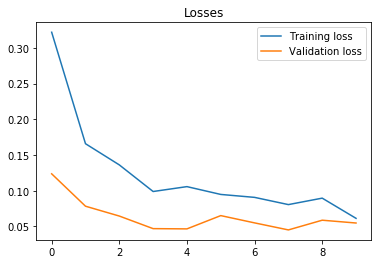

In [0]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [0]:
!git clone https://github.com/pytorch/captum.git
!cd captum; pip install -e .

In [0]:


import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

token_reference = TokenReferenceBase(reference_token_idx = input_ids)
lig = LayerIntegratedGradients(model, model.embedding)